In [10]:
from models.training import *
from models.models_lr import *
import matplotlib.pyplot as plt

In [2]:
def data_generation(A, D, n, sigma, random_seed = 129):
    np.random.seed(random_seed);  epsilon = np.random.randn(n) * sigma;
    X = np.eye(n); beta = np.array([A] * D + [0] * (n - D)); y = beta + epsilon
    return X, y, beta

In [4]:
D = 20; n = 400; sigma_noise = 2.0
learning_rate = 1*1e-2; batch_size = n; num_epoch = 8000;

X, y_10, beta_10 = data_generation(10, D, n, sigma_noise)
x_train = torch.tensor(X, dtype = torch.float);
y_train = torch.tensor(y_10, dtype = torch.float).view(-1,1)

### Feature selection with BetaSS prior

In [5]:
alpha_b = 2.0; beta_b = 38.0 # p~Beta(2, 38)
alpha_g = .001; beta_g = .001 # \lambda~Inv-Gamma(0.001, 0.001)
sigma = 1. # global scale is 1
lr_ssbg_10 = LR_BetaSS(n, sigma, alpha_b, beta_b, alpha_g, beta_g)
training_lr(lr_ssbg_10, x_train, y_train, learning_rate, batch_size, num_epoch)
beta_posterior_10 = lr_ssbg_10.Layer1.mu_beta.detach().numpy()
lambda_posterior_10 = torch.sigmoid(lr_ssbg_10.Layer1.p_logit).detach().numpy()
prediction_ssbg_10 = beta_posterior_10.reshape(-1) * lambda_posterior_10 * torch.exp(lr_ssbg_10.Layer1.mu_logsigma).detach().numpy()

EPOACH 4000: TRAIN LOSS: 2.2654; KL REG: 2392.4431.
EPOACH 8000: TRAIN LOSS: 2.3623; KL REG: 2316.9912.


### Feature selection with DeltaSS prior

In [6]:
p = 0.05 # p=0.05
alpha_g = .001; beta_g = .001 # \lambda~Inv-Gamma(0.001, 0.001)
sigma = 1. # global scale is 1
lr_ssg_10 = LR_DeltaSS(n, sigma, p, alpha_g, beta_g)
training_lr(lr_ssg_10, x_train, y_train, learning_rate, batch_size, num_epoch)
beta_posterior_10 = lr_ssg_10.Layer1.mu_beta.detach().numpy()
lambda_posterior_10 = torch.sigmoid(lr_ssg_10.Layer1.p_logit).detach().numpy()
prediction_ssg_10 = beta_posterior_10.reshape(-1) * lambda_posterior_10 * torch.exp(lr_ssg_10.Layer1.mu_logsigma).detach().numpy()

EPOACH 4000: TRAIN LOSS: 2.3284; KL REG: 2381.3364.
EPOACH 8000: TRAIN LOSS: 2.4172; KL REG: 2315.0457.


### Feature selection with HS prior

In [12]:
b_0 = 1.
b_g = D / (n - D) * sigma_noise; b_g = b_g ** 2 # The effective number of features is set to D
lr_hs_10 = LR_HS(n, b_g, b_0)
training_hs_lr(lr_hs_10, x_train, y_train, learning_rate, batch_size, num_epoch)
lr_hs_10.eval(); prediction_hs_10, _ = lr_hs_10(x_train)
prediction_hs_10 = prediction_hs_10.detach().numpy().reshape(-1)

EPOACH 4000: TRAIN LOSS: 1.1286; KL REG: 650.0728.
EPOACH 8000: TRAIN LOSS: 1.1907; KL REG: 635.9246.


### Feature selection with InfoSS prior

In [17]:
k_min = 0.; k_max = 30.; tau = 5. # m~U[0,30]
alpha_g = 0.001; beta_g = 0.001 # \lambda~Inv-Gamma(0.001, 0.001)
sigma = 1. # global scale is 1
lr_infossg_10 = LR_InfoSS(n, sigma,  alpha_g, beta_g,  k_min, k_max, tau)
training_lr(lr_infossg_10, x_train, y_train, learning_rate, batch_size, num_epoch)
beta_posterior_10 = lr_infossg_10.Layer1.mu_beta.detach().numpy()
lambda_posterior_10 = torch.sigmoid(lr_infossg_10.Layer1.p_logit).detach().numpy()
prediction_infossg_10 = beta_posterior_10.reshape(-1) * lambda_posterior_10 * torch.exp(lr_infossg_10.Layer1.mu_logsigma).detach().numpy()

EPOACH 4000: TRAIN LOSS: 3.0503; KL REG: 2229.9121.
EPOACH 8000: TRAIN LOSS: 3.0666; KL REG: 2170.6162.


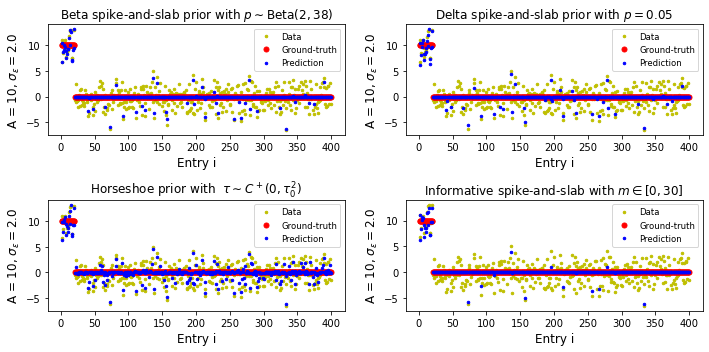

In [18]:
x_axis = np.linspace(1, n, n);  font_size_title = 12

fig_l, axes_l = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 5))
ax_00, ax_01, ax_10, ax_11 = axes_l.flatten()

ax_00.plot(x_axis, y_10, 'y.', markersize=5)
ax_00.plot(x_axis, beta_10, 'r.', markersize=10)
ax_00.plot(x_axis, prediction_ssbg_10, 'b.', markersize=5)
ax_00.legend(['Data', 'Ground-truth', 'Prediction'], fontsize = 8.5)
ax_00.set_xlabel('Entry i', fontsize = font_size_title)
ax_00.set_ylabel(r'A = 10, $\sigma_\epsilon = 2.0$', fontsize = font_size_title)
ax_00.set_title(r'Beta spike-and-slab prior with $p \sim $Beta$(2, 38)$', fontsize = font_size_title) 

ax_01.plot(x_axis, y_10, 'y.', markersize=5)
ax_01.plot(x_axis, beta_10, 'r.', markersize=10)
ax_01.plot(x_axis, prediction_ssg_10, 'b.', markersize=5)
ax_01.legend(['Data', 'Ground-truth', 'Prediction'], fontsize = 8.5)
ax_01.set_xlabel('Entry i', fontsize = font_size_title)
ax_01.set_ylabel(r'A = 10, $\sigma_\epsilon = 2.0$', fontsize = font_size_title)
ax_01.set_title(r'Delta spike-and-slab prior with $p = 0.05$', fontsize = font_size_title) 

ax_10.plot(x_axis, y_10, 'y.', markersize=5)
ax_10.plot(x_axis, beta_10, 'r.', markersize=10)
ax_10.plot(x_axis, prediction_hs_10, 'b.', markersize=5)
ax_10.legend(['Data', 'Ground-truth', 'Prediction'], fontsize = 8.5)
ax_10.set_xlabel('Entry i', fontsize = font_size_title)
ax_10.set_ylabel(r'A = 10, $\sigma_\epsilon = 2.0$', fontsize = font_size_title)
ax_10.set_title(r'Horseshoe prior with  $\tau \sim C^+(0, \tau_0^2)$', fontsize = font_size_title) 

ax_11.plot(x_axis, y_10, 'y.', markersize=5)
ax_11.plot(x_axis, beta_10, 'r.', markersize=10)
ax_11.plot(x_axis, prediction_infossg_10, 'b.', markersize=5)
ax_11.legend(['Data', 'Ground-truth', 'Prediction'], fontsize = 8.5)
ax_11.set_xlabel('Entry i', fontsize = font_size_title)
ax_11.set_ylabel(r'A = 10, $\sigma_\epsilon = 2.0$', fontsize = font_size_title)
ax_11.set_title(r'Informative spike-and-slab with $m \in [0, 30]$', fontsize = font_size_title)  

fig_l.tight_layout()

In [ ]:
|